# Libraries

The libraries listed below will be used in the execution of this project. Assisting us from data processing to prediction. 

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
from unidecode import unidecode
import contractions
import swifter
from textblob import TextBlob

# librosa to process audio files
import librosa as lb
import soundfile as sf
from scipy import signal

# play audio file
from IPython.display import Audio

# import libs for lemmitization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# download lemmitization data|
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# import viz libs
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giliardyminicucci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giliardyminicucci/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/giliardyminicucci/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import the IEMOCAP and MELD dataframes

From the process previously written to extract the information are going to load the dataframe which contains the emotions, transcriptions and other information that will be used in this project

In [5]:
# import IEMOCAP dataset
iemocap_df = pd.read_csv('Data/IEMOCAP/IEMOCAP_DF.csv')
meld_df = pd.read_csv('Data/MELD/MELD_DF.csv')

In [6]:
# only keep the columns from the list
iemocap_df = iemocap_df[['dataset', 'filename', 'filepath', 'transcription', 'emotion_label']]
meld_df = meld_df[['dataset','filename', 'filepath', 'Utterance', 'Emotion']]

# rename meld uterance column to transcription and emotion to emotion_label
meld_col_name = {'Utterance': 'transcription', 'Emotion': 'emotion_label'}
meld_df = meld_df.rename(columns=meld_col_name)

# concat the two dataframes
df = pd.concat([iemocap_df, meld_df], ignore_index=True)

In [7]:
# Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23745 entries, 0 to 23744
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dataset        23745 non-null  object
 1   filename       23745 non-null  object
 2   filepath       23745 non-null  object
 3   transcription  23745 non-null  object
 4   emotion_label  23745 non-null  object
dtypes: object(5)
memory usage: 927.7+ KB


Organise the labels and ensure consistency with the names from IEMOCAP and MELD. Additionally let's remove any labels that are not meaningful such as xxx and other.

In [8]:
# merge excited and happy
df.loc[df.emotion_label == 'excited', 'emotion_label'] = 'happy'

# merge angry and anger
df.loc[df.emotion_label == 'anger', 'emotion_label'] = 'angry'

# merge surprised and surprise
df.loc[df.emotion_label == 'surprised', 'emotion_label'] = 'surprise'

# merge disgusted and disgust
df.loc[df.emotion_label == 'disgusted', 'emotion_label'] = 'disgust'

# merge sad and sadness
df.loc[df.emotion_label == 'sadness', 'emotion_label'] = 'sad'

# merge fear and fearful
df.loc[df.emotion_label == 'fearful', 'emotion_label'] = 'fear'

# Remove xxx and other values
df = df[df.emotion_label != 'xxx']
df = df[df.emotion_label != 'other']


In [9]:
# Distribution of the labels
print(df.emotion_label.value_counts())

emotion_label
neutral       8142
angry         2710
joy           2308
sad           2086
frustrated    1849
surprise      1743
happy         1636
fear           398
disgust        363
Name: count, dtype: int64


# Data Normalisation

During the next cells we will to apply a series of steps to normalise the data an ensure an uniform representation of the data. For this project it will be applied the following:

•	Lowercase sentences. \
•	Remove links, special characters, double or extra spaces, and punctuation. \
•	Standardised accents and retained alphanumeric characters. \
•	Expand contractions and abbreviations. \
•	Lemmatization 

In [10]:
# Apply lemmatization
wl = WordNetLemmatizer()

# https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
# Following the method from stackoverflow for get_wordnet_pos can get the pos tag for each word and then apply lemmatization
def get_wordnet_pos(tag):
    """
        This function maps the POS tag to the first character
        tag: POS tag
        return: WordNet POS tag
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence and return the lemmatized sentence
def lemmatizer(text):
    """
        This function lemmatizes the words in a sentence
        text: Sentence to lemmatize
        return: Lemmatized sentence
    """
    # Get position tags
    word_pos_tags = nltk.pos_tag(nltk.word_tokenize(text))
    # Map the position tag and lemmatize the word
    lem = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]

    # Join the list of words back into a sentence
    return " ".join(lem)

In [11]:
def normalise_text(text):
    """
        This function normalises the received sentence by applying multiple cleaning steps
        text: Sentence to normalise
        return: Normalised text
    """
    # Basic pre-processing
    text = text.lower() # convert to lowercase
    text = re.sub(r"\r|\n|\t", "", text) # Remove new lines, tabs etc
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # remove urls
    text = contractions.fix(text) # expand contractions

    text = unidecode(text) # remove any values with accents

    text = re.sub(r"[^a-z0-9]"," ", text) # remove non alphanumeric characters
    text = re.sub(r"\'", " ", text) # remove quotes and apostrophes
    text = re.sub(r"\s+"," ", text) # remove extra spaces

    text = lemmatizer(text) # lemmatize words

    return text

Apply the normalisation steps and add to a new column in the dataframe

In [12]:
# Apply the clean_text function to the text column and create a new one named clean_text
df['clean_text'] = df['transcription'].swifter.apply(normalise_text)

Pandas Apply:   0%|          | 0/21235 [00:00<?, ?it/s]

In [15]:
df.head(10)

,dataset,filename,filepath,transcription,emotion_label,clean_text,emotion_num,nr_filepath
0,IEMOCAP,Ses04M_script02_2_M040,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,I don't know. It seemed like a good spot to m...,happy,i do not know it seem like a good spot to me i...,6,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M040...
1,IEMOCAP,Ses04M_script02_2_M041,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Shh. If we're very quiet, the fish might come.",happy,shh if we be very quiet the fish might come,6,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M041...
2,IEMOCAP,Ses04M_script02_2_F029,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,But this isn't anything like I thought anythin...,angry,but this be not anything like i think anything...,1,NormalisedAudio/IEMOCAP/Ses04M_script02_2_F029...
3,IEMOCAP,Ses04M_script02_2_M034,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"No, I know, me neither.",angry,no i know me neither,1,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M034...
4,IEMOCAP,Ses04M_script02_2_M020,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Wait a minute, I've got it.",neutral,wait a minute i have get it,0,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M020...
5,IEMOCAP,Ses04M_script02_2_M021,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"It was in the car, right? Driving past the Kn...",neutral,it be in the car right drive past the knickerb...,0,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M021...
6,IEMOCAP,Ses04M_script02_2_M035,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,I'm doing the best I can.,frustrated,i be do the best i can,4,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M035...
7,IEMOCAP,Ses04M_script02_2_F028,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Oh, right, sure. This is standing on the beac...",angry,oh right sure this be stand on the beach this ...,1,NormalisedAudio/IEMOCAP/Ses04M_script02_2_F028...
8,IEMOCAP,Ses04M_script02_2_F000,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Look at this, goose bumps.",neutral,look at this goose bump,0,NormalisedAudio/IEMOCAP/Ses04M_script02_2_F000...
9,IEMOCAP,Ses04M_script02_2_F016,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"It was about four years ago, right after we go...",sad,it be about four year ago right after we get m...,3,NormalisedAudio/IEMOCAP/Ses04M_script02_2_F016...


In [5]:
# Load dataframe
df = pd.read_csv('Data/Final_DF.csv')

### Sentence length analysis

Before we proceed with the data split and tokenization of the dataset, we must first examine the cleaned dataset to find out the length and frequency of the transcriptions.

In [6]:
# Histogram of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(x) for x in df.clean_text], bins=80)
plt.title('Sentence Length')
plt.show()

TypeError: object of type 'float' has no len()

<Figure size 1000x500 with 0 Axes>

In [24]:
# Check the max length of a sentence
max_len = max([len(x) for x in df.clean_text])
print(f'Max sentence length: {max_len}')

# Variable that sums of sentences with length greater than 180
sum_val = sum([1 for x in df.clean_text if len(x) > 180])

# Number of sentences have length greater than 180
print(f'Number of sentences with length greater than 180: {sum_val}')

# Total number of tweets in the dataframe
print(f'Number of tweets in the dataframe: {df.shape[0]}')

# Percentage of sentences with length greater than 180
print(f'Percentage of sentences with length greater than 180: {sum_val*100/df.shape[0]:.4f}%')

Max sentence length: 509
Number of sentences with length greater than 180: 220
Number of tweets in the dataframe: 21235
Percentage of sentences with length greater than 180: 1.0360%


In [25]:
# convert emotions to numeric values read unique emotions
emotions = df.emotion_label.unique()

# create emotion to numeric value mapping
emotion_num = {
                'neutral': 0,
                'angry': 1,
                'joy': 2,
                'sad': 3,
                'frustrated': 4,
                'surprise': 5,
                'happy': 6,
                'fear': 7,
                'disgust': 8,
            }

# map the emotions to numeric values
df['emotion_num'] = df['emotion_label'].map(emotion_num)

## Wav2Vec ASR

To examine the findings using ASR, Wav2Vec will be used, which employs neural networks and is capable of interpreting spoken language with exceptional precision. Wav2Vec is a free tool that allows quick and trustworthy transcriptions from audio files.

In [7]:
import librosa as lr
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Function to transcribe the audio file to text, it returns the text value
def transc_wav2vec2(audio_file):
    """
        This function transcribes the audio file to text using the Wav2Vec2 model
        audio_file: Path to the audio file
        return: Transcribed text
    """
    # load the processor
    tokenizer = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-robust-ft-libri-960h")
    model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-robust-ft-libri-960h")

    # load the audio data, set the sampling rate to 16kHz
    audio, sr = lr.load(audio_file, sr=16000)

    # tokenize
    input_values = tokenizer(audio, sampling_rate=sr, return_tensors="pt").input_values
    
    # retrieve logits
    logits = model(input_values).logits

    # decode the text using the tokenizer 
    results = torch.argmax(logits, dim = -1)
    text = tokenizer.batch_decode(results)[0].lower()
    return text

In [8]:
def wav2vec_transc(df, file_loc):
    """
        This function transcribes the audio files in the dataframe and writes the transcription to the dataframe
        df: Dataframe to transcribe
        file_loc: Column name of the file location
    """
    for idx, row in df.iterrows():
        input_file = row[file_loc]
        # check if the asr_transcription is null and transcribe the audio file
        if pd.isnull(row['asr_transcription']):
            try:
                # transcribe the audio file
                transcription = transc_wav2vec2(input_file)
                # write the transcription to the dataframe
                df.at[idx, 'asr_transcription'] = transcription
                
                # export the file to a csv as its being processed
                df.to_csv('Data/missing_rows.csv', index=False)
            except:
                print(f'Error processing file: {input_file}')
                continue
        else:
            print(f'File already processed: {input_file}, transcription: {row["asr_transcription"]}')
            continue

In [2]:
test10 = pd.read_csv('Data/missing_rows.csv')

In [3]:
test10

,dataset,filename,filepath,transcription,emotion_label,clean_text,emotion_num,nr_filepath,asr_transcription
0,MELD,dev_dia1_utt8,Data/MELD/dev/mp4/dev_dia1_utt8.mp4,On the touchy.,neutral,on the touchy,0,NormalisedAudio/MELD/dev_dia1_utt8_NR.wav,No value
1,MELD,dev_dia10_utt5,Data/MELD/dev/mp4/dev_dia10_utt5.mp4,"Yeah, no one talks like that!",angry,yeah no one talk like that,1,NormalisedAudio/MELD/dev_dia10_utt5_NR.wav,No value
2,MELD,dev_dia105_utt1,Data/MELD/dev/mp4/dev_dia105_utt1.mp4,"Hi, this is Monica from the plane?",neutral,hi this be monica from the plane,0,NormalisedAudio/MELD/dev_dia105_utt1_NR.wav,No value
3,MELD,dev_dia108_utt5,Data/MELD/dev/mp4/dev_dia108_utt5.mp4,Ow!,angry,ow,1,NormalisedAudio/MELD/dev_dia108_utt5_NR.wav,No value
4,MELD,dev_dia11_utt2,Data/MELD/dev/mp4/dev_dia11_utt2.mp4,"Wait, Rach! Where's the other one?",neutral,wait rach where be the other one,0,NormalisedAudio/MELD/dev_dia11_utt2_NR.wav,No value
...,...,...,...,...,...,...,...,...,...
617,MELD,train_dia964_utt9,Data/MELD/train/mp4/train_dia964_utt9.mp4,Oh not again!,angry,oh not again,1,NormalisedAudio/MELD/train_dia964_utt9_NR.wav,NaN
618,MELD,train_dia993_utt1,Data/MELD/train/mp4/train_dia993_utt1.mp4,Hey!,joy,hey,2,NormalisedAudio/MELD/train_dia993_utt1_NR.wav,NaN
619,MELD,train_dia996_utt15,Data/MELD/train/mp4/train_dia996_utt15.mp4,Or?,angry,or,1,NormalisedAudio/MELD/train_dia996_utt15_NR.wav,NaN
620,MELD,train_dia996_utt18,Data/MELD/train/mp4/train_dia996_utt18.mp4,It's you that is backwards.,angry,it be you that be backwards,1,NormalisedAudio/MELD/train_dia996_utt18_NR.wav,NaN


In [40]:
test10.to_csv('Data/Final_DF_Transcript_test20.csv', index=False)

In [1]:
test10

NameError: name 'test10' is not defined

In [9]:
# Function to iterate over the file list in the dataframe and call the normalise_lpass function
wav2vec_transc(test10, 'nr_filepath')

File already processed: NormalisedAudio/MELD/dev_dia1_utt8_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia10_utt5_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia105_utt1_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia108_utt5_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia11_utt2_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia11_utt9_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia113_utt3_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia15_utt6_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia18_utt0_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia18_utt1_NR.wav, transcription: No value
File already processed: NormalisedAudio/MELD/dev_dia23_utt10_NR.wav, transcrip

2024-02-04 14:51:20.290894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already processed: NormalisedAudio/MELD/test_dia225_utt5_NR.wav, transcription: a i just wanted them to hear it from somebody else
File already processed: NormalisedAudio/MELD/test_dia226_utt0_NR.wav, transcription: te heything's going to talk
File already processed: NormalisedAudio/MELD/test_dia226_utt1_NR.wav, transcription: gid
File already processed: NormalisedAudio/MELD/test_dia226_utt2_NR.wav, transcription: although you know he he's a private guy
File already processed: NormalisedAudio/MELD/test_dia226_utt3_NR.wav, transcription: i wish i could get him to open up a little bit to share some feelings
File already processed: NormalisedAudio/MELD/test_dia226_utt4_NR.wav, transcription: at's easy you just have to think of im as it as a jar of pickles that won't open
File already processed: NormalisedAudio/MELD/test_dia226_utt5_NR.wav, transcription: so what he saying i should run him under some hot water and bage his head against a table
File already processed: NormalisedAudio/M

In [21]:
# Export the dataframe to a csv file
df.to_csv('Data/Final_DF_Transc.csv', index=False)

# Audio pre-processing

During the steps below we will apply normalisation to the audio files to ensure consitency. The steps applied are:

•	Normalise audio volume \
•	Apply low pass filter to reduce noise


In [28]:
# Load the audio file
audio_file = df.filepath.iloc[0]
audio, sr = lb.load(audio_file)

# play audio file
Audio(audio, rate=sr)

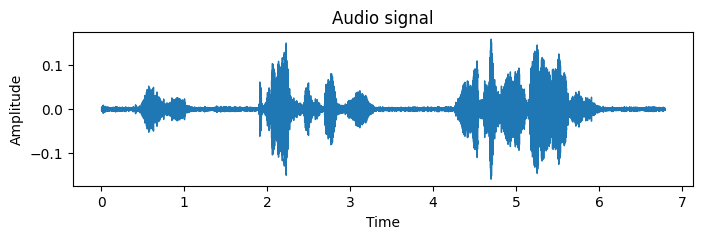

In [29]:
# Plot the audio signal just to have an idea of what it looks like
plt.figure(figsize=(8, 2))
lb.display.waveshow(audio, sr=sr)
plt.title('Audio signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
def create_folders(datasets, path = 'NormalisedAudio'):
    """
        This function creates folders for each dataset to add the normalised files
        df: Dataframe
        col: Column name
        path: Path to create the folders
    """
    # Get the locale types from the pd dataframe
    make_dir = path + '/' + datasets
    # create a directory for each type
    for dir in make_dir:
        os.makedirs(dir, exist_ok=True) 
        
        
def normalise_lpass(audio_file, output_file):
    """
        This function applies the normalisation and low pass filter to the audio file
        audio_file: Input audio file path
        output_file: Output audio file pathname
    """
    # Load the audio file with librosa
    audio, sr = lb.load(audio_file)

    # Normalise the audio using librosa
    normalised_audio = lb.util.normalize(audio)

    # Add low pass filter to improve the audio quality and remove some of the background noise
    a, b = signal.butter(20, 6000/(sr/2), btype='lowpass')
    rn_lpass = signal.lfilter(a,b,normalised_audio)

    # output the new file
    sf.write(output_file, rn_lpass, sr)
    print(f'Successfully normalised: {output_file}')


def audio_preprocessing(df, file_loc, dataset = 'dataset', output_loc='NormalisedAudio', filename='filename'):
    """
        This function iterates over the file list in the dataframe and calls the normalise_lpass function
        df: Dataframe
        file_loc: Column name for the file path
        dataset: Dataset column name
        output_loc: Path to create the folders
        filename: Filename column name
    """
    for idx, row in df.iterrows():
        input_file = row[file_loc]
        output_file = output_loc + '/' + row[dataset]  + '/' + row[filename] + '_NR.wav'

        # write to df a new column nr_filepath the output file
        df.loc[idx, 'nr_filepath'] = output_file
        normalise_lpass(input_file, output_file)

# Function to iterate over the file list in the dataframe and call the normalise_lpass function
audio_preprocessing(df, 'filepath')

In [46]:
df

,dataset,filename,filepath,transcription,emotion_label,clean_text,emotion_num,nr_filepath
1,IEMOCAP,Ses04M_script02_2_M040,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,I don't know. It seemed like a good spot to m...,happy,i do not know it seem like a good spot to me i...,6,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M040...
2,IEMOCAP,Ses04M_script02_2_M041,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Shh. If we're very quiet, the fish might come.",happy,shh if we be very quiet the fish might come,6,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M041...
5,IEMOCAP,Ses04M_script02_2_F029,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,But this isn't anything like I thought anythin...,angry,but this be not anything like i think anything...,1,NormalisedAudio/IEMOCAP/Ses04M_script02_2_F029...
6,IEMOCAP,Ses04M_script02_2_M034,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"No, I know, me neither.",angry,no i know me neither,1,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M034...
7,IEMOCAP,Ses04M_script02_2_M020,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Wait a minute, I've got it.",neutral,wait a minute i have get it,0,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M020...
...,...,...,...,...,...,...,...,...
23740,MELD,test_dia279_utt11,Data/MELD/test/mp4/test_dia279_utt11.mp4,"Yeah, I mean, come on Ross, no one will even n...",neutral,yeah i mean come on ross no one will even noti...,0,NormalisedAudio/MELD/test_dia279_utt11_NR.wav
23741,MELD,test_dia279_utt12,Data/MELD/test/mp4/test_dia279_utt12.mp4,They're not listening too me?,surprise,they be not listen too me,5,NormalisedAudio/MELD/test_dia279_utt12_NR.wav
23742,MELD,test_dia279_utt13,Data/MELD/test/mp4/test_dia279_utt13.mp4,Of course they're listening to you! Everybody ...,neutral,of course they be listen to you everybody list...,0,NormalisedAudio/MELD/test_dia279_utt13_NR.wav
23743,MELD,test_dia279_utt14,Data/MELD/test/mp4/test_dia279_utt14.mp4,Monica you really think I should try this phas...,neutral,monica you really think i should try this phas...,0,NormalisedAudio/MELD/test_dia279_utt14_NR.wav


In [43]:
# check that we have the same number of files in the dataframe and the folder
print(f'Number of files in the dataframe: {df.shape[0]}')
print(f'Number of files in the folder: {len(os.listdir("NormalisedAudio/MELD")) + len(os.listdir("NormalisedAudio/IEMOCAP"))}')

# check number of files from IEMOCAP dataframe and in the folder
print(f'Number of files from IEMOCAP: {len(os.listdir("NormalisedAudio/IEMOCAP"))}')
print(f'Number of files from IEMOCAP in the dataframe: {df[df.dataset == "IEMOCAP"].shape[0]}')

# check number of files from MELD dataframe and in the folder
print(f'Number of files from MELD: {len(os.listdir("NormalisedAudio/MELD"))}')
print(f'Number of files from MELD in the dataframe: {df[df.dataset == "MELD"].shape[0]}')

Number of files from IEMOCAP: 7529
Number of files from IEMOCAP in the dataframe: 7529
Number of files from MELD: 13706
Number of files from MELD in the dataframe: 13706


In [188]:
# Export the dataframe to a csv file
df.to_csv('Data/Final_DF.csv', index=False)

In [27]:
df

,dataset,filename,filepath,transcription,emotion_label,clean_text,emotion_num,nr_filepath
1,IEMOCAP,Ses04M_script02_2_M040,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,I don't know. It seemed like a good spot to m...,happy,i do not know it seem like a good spot to me i...,6,None
2,IEMOCAP,Ses04M_script02_2_M041,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Shh. If we're very quiet, the fish might come.",happy,shh if we be very quiet the fish might come,6,None
5,IEMOCAP,Ses04M_script02_2_F029,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,But this isn't anything like I thought anythin...,angry,but this be not anything like i think anything...,1,None
6,IEMOCAP,Ses04M_script02_2_M034,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"No, I know, me neither.",angry,no i know me neither,1,None
7,IEMOCAP,Ses04M_script02_2_M020,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Wait a minute, I've got it.",neutral,wait a minute i have get it,0,None
...,...,...,...,...,...,...,...,...
23740,MELD,dia279_utt11,Data/MELD/test/mp4/dia279_utt11.mp4,"Yeah, I mean, come on Ross, no one will even n...",neutral,yeah i mean come on ross no one will even noti...,0,None
23741,MELD,dia279_utt12,Data/MELD/test/mp4/dia279_utt12.mp4,They're not listening too me?,surprise,they be not listen too me,5,None
23742,MELD,dia279_utt13,Data/MELD/test/mp4/dia279_utt13.mp4,Of course they're listening to you! Everybody ...,neutral,of course they be listen to you everybody list...,0,None
23743,MELD,dia279_utt14,Data/MELD/test/mp4/dia279_utt14.mp4,Monica you really think I should try this phas...,neutral,monica you really think i should try this phas...,0,None


# Data split

The dataset for this project will be split into training, validation, and test sets. Following the ratio 80:10:10, respectively.

In [191]:
# create a function to split the dataset into train, validation and test sets
def split_data(df, stratify_col, train_test_size=0.2, val_test_size=0.5, random_state=42):
    """
        This function splits the dataset into train, validation and test sets
        df: Dataframe to split
        test_size: Size of the test set
        val_size: Size of the validation set
        random_state: Random state for reproducibility
        return: Train, validation and test sets
    """
    # Split the dataframe into train and test sets (80/20)
    train_df, test_df = train_test_split(df, test_size=train_test_size, random_state=random_state, stratify=df[stratify_col])

    # Split the train set into train and validation sets (50/50)
    val_df, test_df = train_test_split(test_df, test_size=val_test_size, random_state=random_state, stratify=test_df[stratify_col])

    return train_df, val_df, test_df

In [192]:
# Split the dataframe into train, validation and test sets
train_df, val_df, test_df = split_data(df, 'num_label')

We can investigate the results by printing the shape of each dataset. Furthermore, we can also check if the stratify worked correctly as the dataset is imbalanced.

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((5904, 12), (738, 12), (738, 12))

In [ ]:
# count the number of emotion labels in each set
print(f'{train_df.emotion_label.value_counts()}\n')
print(f'{val_df.emotion_label.value_counts()}\n')
print(f'{test_df.emotion_label.value_counts()}\n')

emotion_label
frustrated    1479
neutral       1367
angry          882
sad            867
excited        833
happy          476
Name: count, dtype: int64

emotion_label
frustrated    185
neutral       171
angry         111
sad           108
excited       104
happy          59
Name: count, dtype: int64

emotion_label
frustrated    185
neutral       170
angry         110
sad           109
excited       104
happy          60
Name: count, dtype: int64



## Tokenization for text classification

Machine learning models cannot simply read the text as is, hence text must be transformed into a model-compatible format, therefore words must be tokenized, which is a process that translates words to a numerical representation

In [ ]:
# Create the tokenizer object using the BERT vocab bert-base-uncased file
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Function to tokenize the sentences using the BERT tokenizer
def bert_tokenizer(sentence, labels_val, max_len):
    """
        Perform required preprocessing steps for pretrained BERT.
        sentence: Sentence to tokenize
        labels: List of labels to be encoded
        max_len: Max length of the sentence (truncating point/padding point)
        return: Tokenized sentence
    """

    # Initialise lists to store outputs
    input_ids = []
    attention_masks = []

    # Iterate through each sentence and encode them
    # https://huggingface.co/transformers/v2.11.0/_modules/transformers/tokenization_utils.html#PreTrainedTokenizer.encode_plus
    # encode_plus method ^^
    for sent in sentence:
        encoded_sent = tokenizer.encode_plus(
            text = sent,                    # Sentence to encode
            add_special_tokens = True,      # [CLS] and [SEP] tokens
            max_length = max_len,           # Max length
            padding = 'max_length',         # Pad sentence to max length
            truncation = True,              # Truncate if longer than max length
            return_attention_mask = True    # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to numpy arrays for training/prediction
    input_ids = np.array(input_ids, dtype='int64')
    attention_masks = np.array(attention_masks, dtype='int64')
    labels = np.array(labels_val, dtype='int64')

    return input_ids, attention_masks, labels

Execute the tokenization to all datasets using the bert_tokenizer function.

In [ ]:
# Set the maximum length of the sentences
max_len = 200

# Tokenize the train, validation and test sets
train_inputs, train_masks, train_labels = bert_tokenizer(train_df['clean_text'], train_df['num_label'], max_len)
val_inputs, val_masks, val_labels = bert_tokenizer(val_df['clean_text'],  val_df['num_label'], max_len)
test_inputs, test_masks, test_labels = bert_tokenizer(test_df['clean_text'], test_df['num_label'], max_len)

# Print the shapes of the inputs
print(f'Train input_ids shape: {train_inputs.shape}')
print(f'Validation input_ids shape: {val_inputs.shape}')
print(f'Test input_ids shape: {test_inputs.shape}')

Train input_ids shape: (5904, 200)
Validation input_ids shape: (738, 200)
Test input_ids shape: (738, 200)


Printing an example of a tokenized sentence

In [ ]:
# Print the original train input sentence and its tokenized ids
rand = np.random.randint(0, train_inputs.shape[0])

print(f'Original train sentence: {train_df.clean_text.iloc[rand]}')
print(f'Token ids of train sentence: {train_inputs[rand]}')
print(f'Decoded train sentence: {tokenizer.decode(train_inputs[rand])}')

Original train sentence: you know he be go to and we all the way up to the end we be just talk about how you know all the stuff we be go to do and you know when he finally kick this stupid cancer you know and we be go to
Token ids of train sentence: [ 101 2017 2113 2002 2022 2175 2000 1998 2057 2035 1996 2126 2039 2000
 1996 2203 2057 2022 2074 2831 2055 2129 2017 2113 2035 1996 4933 2057
 2022 2175 2000 2079 1998 2017 2113 2043 2002 2633 5926 2023 5236 4456
 2017 2113 1998 2057 2022 2175 2000  102    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0

### BERT Pre-Trained Model

The text model was built using a pre-trained model that is widely known in the NLP industry for its proven effectiveness. TFBertForSequenceClassification was used for the implementation, it combines BERT with a sequence classification head, ideal for text analysis. The 'bert-base-uncased' was used for transfer learning, pre-trained on BookCorpus and English Wikipedia. Training included the inputs, attention masks, and a dropout (0.2) to prevent overfitting. The final layer utilizes softmax activation to output projections.

In [ ]:
len_labels = len(num_to_emotion)
len_labels

6

In [ ]:
bert_pretrained = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',          # 12-layer BERT model uncased vocab.
    num_labels = len_labels)      # The number of output labels

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def build_text_model(bert_model, shape_size):
    """
        This function builds the BERT Text model
        bert_model: BERT pretrained model
        shape_size: Shape size of the input
        return: BERT model
    """
    input_ids = Input(shape=(shape_size,), dtype=tf.int32, name='input_ids') # input ids layer
    attention_masks = Input(shape=(shape_size,), dtype=tf.int32, name='attention_masks') # attention masks layer

    output = bert_model(input_ids, attention_masks)[0] # Output of the BERT model last hidden state
    output = Dropout(0.5)(output) # Dropout layer to reduce overfitting
    output = Dense(len_labels, activation='softmax')(output) # Dense layer for classification
    model = Model(inputs = [input_ids, attention_masks],outputs = output)

    return model

# Build the BERT model
bert_model = build_text_model(bert_pretrained, max_len)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094868   ['input_ids[0][0]',           
 ification_1 (TFBertForSequ  (loss=None, logits=(None,    54         'attention_masks[0][0]']     
 enceClassification)         6),                                                              

In [ ]:
# bert_model.load_weights('/content/drive/MyDrive/BERT/bert_model_2exec.keras')

In [ ]:
bert_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

NameError: name 'bert_model' is not defined

In [ ]:
history_text = bert_model.fit(
    [train_inputs, train_masks],
    train_labels,
    validation_data=([val_inputs, val_masks], val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
 17/369 [>.............................] - ETA: 1:30:59 - loss: 1.8365 - accuracy: 0.1912

KeyboardInterrupt: 

In [ ]:
# bert_model.save_weights('/content/drive/MyDrive/BERT/bert_model_IEMOCAP.keras')

In [ ]:
bert_model.load_weights('/content/drive/MyDrive/BERT/bert_model_IEMOCAP.keras')

In [ ]:
# Predict the results using the unseen test inputs
y_pred_bert= bert_model.predict([test_inputs, test_masks])
y_pred_bert = np.argmax(y_pred_bert, axis=1)

# print the index to class and the algorithm performance
print(index_to_class)
print(classification_report(test_labels, y_pred_bert))

24/24 [==============================] - 6s 140ms/step
              precision    recall  f1-score   support

           0       0.41      0.38      0.40        60
           1       0.54      0.56      0.55       110
           2       0.49      0.53      0.51       170
           3       0.52      0.53      0.52       185
           4       0.63      0.65      0.64       109
           5       0.59      0.45      0.51       104

    accuracy                           0.53       738
   macro avg       0.53      0.52      0.52       738
weighted avg       0.53      0.53      0.53       738



# Audio emotion recognition

2. Reshaped Array Shape:

(1, features.shape[0], features.shape[1], 1) indicates a 4D array with:

Batch size: 1 (as only one audio file was processed at a time)

Time dimension: features.shape[0] (number of time frames in the features)

Frequency dimension: features.shape[1] (number of frequency bins in the features)

Channel dimension: 1 (as the features were single-channel) /  

The standardise function, calculates the standard deviation and mean values, followed by subtracting the mean from each feature and dividing by the standard deviation which generates a value between 0 and 1, ensuring consistent scales, that consequently mitigates bias in the learning process.

In [ ]:
def standardise(features):
    # calculate the standard dev
    std = np.std(features, axis=0)
    std[std == 0] = 1e-10 # handle division by zero by replacing it with small val
    mean = features.mean(axis=0)
    features = (features - mean) / std

    return features

The extract_audio_features function utilising librosa extracts the MFCC, ZCR, Chroma, RMS and Mel features in frequency bin format, which are stacked and standardised. 

In [ ]:
def extract_audio_features(file_path):
    """
        Extract MFCC, ZCR, Chroma, RMS and mel features from the audio files.
        file_path: Path to the audio file to extract features from
        return: Tuple containing the extracted features
    """

    # Extract features
    audio, sr = lb.load(file_path)

    # MFCC
    mfcc = lb.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)

    # Zero-crossing rate
    zcr = lb.feature.zero_crossing_rate(y=audio)

    # Chroma_stft
    stft  = np.abs(lb.stft(audio))
    chroma = lb.feature.chroma_stft(S=stft, sr=sr)

    # RMS
    rms = lb.feature.rms(y=audio)

    # MelSpectogram
    mel = lb.feature.melspectrogram(y=audio, sr=sr)

    # Combine features into a 2D array
    # Transpose the values making rows the features and columns the observations
    features = np.vstack([mfcc, zcr, chroma, rms, mel]).T
    features = standardise(features)

    # Reshape the features to match the format for the CNN
    features = features.reshape(1, features.shape[0], features.shape[1], 1)

    return features

The results are padded or truncated to maintain consistency accross the lenght sizes

In [ ]:
# pad the longest feature length
def pad_features(features):
    """
        Pad the longest feature length
        features: List of features to pad
        return: Padded features
    """
    # set the max length of features to 400
    max_length = 400

    #iterate over the features list and pad if the length is less than the max length else truncate to the max length
    for i in range(len(features)):
        if features[i].shape[1] < max_length:
            features[i] = np.pad(features[i], ((0, 0), (0, max_length - features[i].shape[1]), (0, 0), (0, 0)), mode='constant')
        else:
            features[i] = features[i][:, :max_length, :, :]

    return features

Iterate over the files and return the encoded values and their respective labels

In [ ]:
def load_data(df):
    X = []

    # iterate over the file paths to extract the features
    for file in df.nr_filepath:
        feature=extract_audio_features(file)
        X.append(feature)

    # pad the features
    X = pad_features(X)

    # Combine features from all files into a single NumPy array
    X = np.concatenate(X, axis=0)

    # convert df num_label to list
    y = df.num_label.to_list()

    return X,y

In [ ]:
# load the data for the train, val and test sets
X_train, y_train = load_data(train_df)
X_val, y_val = load_data(val_df)
X_test, y_test = load_data(test_df)

In [ ]:
# convert the labels to categorical (one hot vector)
y_train = to_categorical(y_train, num_classes=len_labels)
y_val = to_categorical(y_val, num_classes=len_labels)
y_test = to_categorical(y_test, num_classes=len_labels)

X values should have 4 dimensions

y values should have 2 dimensions

In [ ]:
# print the shape of the data
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5904, 400, 162, 1),
 (5904, 6),
 (738, 400, 162, 1),
 (738, 6),
 (738, 400, 162, 1),
 (738, 6))

Build the Audio model

The audio model employs a Conv2D architecture built using a sequential tf.keras model, containing multiple Conv2D layers and several filter widths sizes (256, 128, 64). This filter approach collects information at various spatial scales, with bigger filters capturing wider patterns and smaller filters capturing finer details. To down-sample spatial data while keeping critical information during feature extraction, MaxPooling2D layers are used. To avoid overfitting, two Dropout layers for regularisation were added and a dense layer with softmax to output emotion class predictions.

In [ ]:
audio_model = Sequential([
    # initial layer with input shape
    Conv2D(256, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    # Masking layer to mask the padded values
    Masking(mask_value=0.0),
    # MaxPooling2D to downsample the feature maps
    MaxPooling2D((2, 2)),
    # Conv2D layer with 256 filters and relu activation
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5), # Dropout layer to reduce overfitting
    # Conv2D layer with 128 filters and relu activation
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Conv2D layer with 64 filters and relu activation
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(), # Flatten layer to convert 2D to 1D
    Dropout(0.5), # Dropout layer to reduce overfitting
    Dense(32, activation='relu'),
    Dense(len(df.num_label.unique()), activation='softmax') # Output layer
])

In [ ]:
audio_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

audio_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 398, 160, 256)     2560      
                                                                 
 masking_1 (Masking)         (None, 398, 160, 256)     0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 199, 80, 256)      0         
 g2D)                                                            
                                                                 


 conv2d_5 (Conv2D)           (None, 197, 78, 256)      590080    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 98, 39, 256)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 98, 39, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 37, 128)       295040    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 18, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 16, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 8, 64)         0         
 g2D)     

In [ ]:
history_audio = audio_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4),
      ]
)

Epoch 1/20
  2/369 [..............................] - ETA: 1:16:22 - loss: 1.8142 - accuracy: 0.1250

KeyboardInterrupt: 

In [ ]:
audio_model.save('/content/drive/MyDrive/BERT/CNN2D_model_IEMOCAP.keras')

In [ ]:
# test model
audio_model.evaluate(X_test, y_test)

# predict on test data
y_pred = audio_model.predict(X_test)

# convert predictions to one hot vectors
y_pred = np.argmax(y_pred, axis=1)

# Convert from one hot vectors to integers
y_labels = np.argmax(y_test, axis=1)

24/24 [==============================] - 1s 41ms/step


2

In [ ]:
# print history classification_report
print(classification_report(y_labels, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.02      0.03        60
           1       0.46      0.33      0.38       110
           2       0.35      0.52      0.42       170
           3       0.35      0.41      0.38       185
           4       0.42      0.63      0.51       109
           5       0.21      0.05      0.08       104

    accuracy                           0.37       738
   macro avg       0.33      0.33      0.30       738
weighted avg       0.35      0.37      0.34       738



# Model Fusion

In [ ]:
# Get individual predictions
audio_predict = audio_model.predict(X_test)
text_predict = bert_model.predict([test_inputs,test_masks])

24/24 [==============================] - 7s 141ms/step


In [ ]:
# Late fusion - concatenating the values from both trained models
fusion_inputs = np.concatenate((audio_predict, text_predict), axis=1)

fusion_model = Sequential([
    Dense(128, activation='relu', input_shape=(12,)),  # Dense input layer
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(64, activation='relu'), # Dense hidden layer
    Dense(len(df.num_label.unique()), activation='softmax') # Output layer
])

In [ ]:
fusion_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

fusion_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 128)               1664      
                                                                 
 dropout_49 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 6)                 390       
                                                                 
Total params: 10310 (40.27 KB)
Trainable params: 10310 (40.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_fusion = fusion_model.fit(
    fusion_inputs,
    test_labels,
    epochs=20,
    batch_size=128,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
      ]
)

Epoch 1/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4472 - accuracy: 0.4932 - lr: 1.0000e-07
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4457 - accuracy: 0.4810 - lr: 1.0000e-07
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4381 - accuracy: 0.4878 - lr: 1.0000e-07
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4449 - accuracy: 0.4729 - lr: 1.0000e-07
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4379 - accuracy: 0.4851 - lr: 1.0000e-07
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4474 - accuracy: 0.4824 - lr: 1.0000e-07
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 1.4421 - accuracy: 0.4756 - lr: 1.0000e-07
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4476 - accuracy: 0.4919 - lr: 1.0000e-07
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4454 - accuracy

In [ ]:
# predict on test data
y_pred = fusion_model.predict(fusion_inputs)

# convert predictions to one hot vectors
y_pred = np.argmax(y_pred, axis=1)

# print history classification_report
print(classification_report(test_labels, y_pred, zero_division=True))

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        60
           1       0.79      0.34      0.47       110
           2       0.40      0.61      0.48       170
           3       0.47      0.64      0.55       185
           4       0.61      0.52      0.56       109
           5       0.59      0.50      0.54       104

    accuracy                           0.50       738
   macro avg       0.64      0.43      0.43       738
weighted avg       0.58      0.50      0.48       738



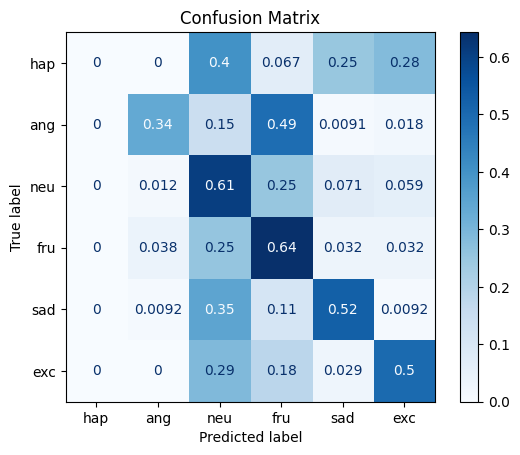

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(test_labels, y_pred, labels_list)

## Convert the MFCC feature to image

In [45]:
# Create a function that uses librosa to extract the MFCC to an image and save the image in a folder

# def extract_mfcc_image(file_path, output_path):
#     """
#         This function uses librosa to extract the MFCC to an image and save the image in a folder
#         file_path: Path to the audio file
#         output_path: Path to save the image
#     """

file_path = df.filepath.iloc[100]
output_path = 'test100.png'


# Load the audio file
audio, sr = lb.load(file_path)

# Extract MFCC features
mfcc = lb.feature.mfcc(y=audio, sr=sr)

# Convert the MFCC to an image
fig = plt.Figure()
# canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
p = lb.display.specshow(mfcc, ax=ax)
fig.savefig(output_path, dpi=1000, bbox_inches='tight', pad_inches=0)




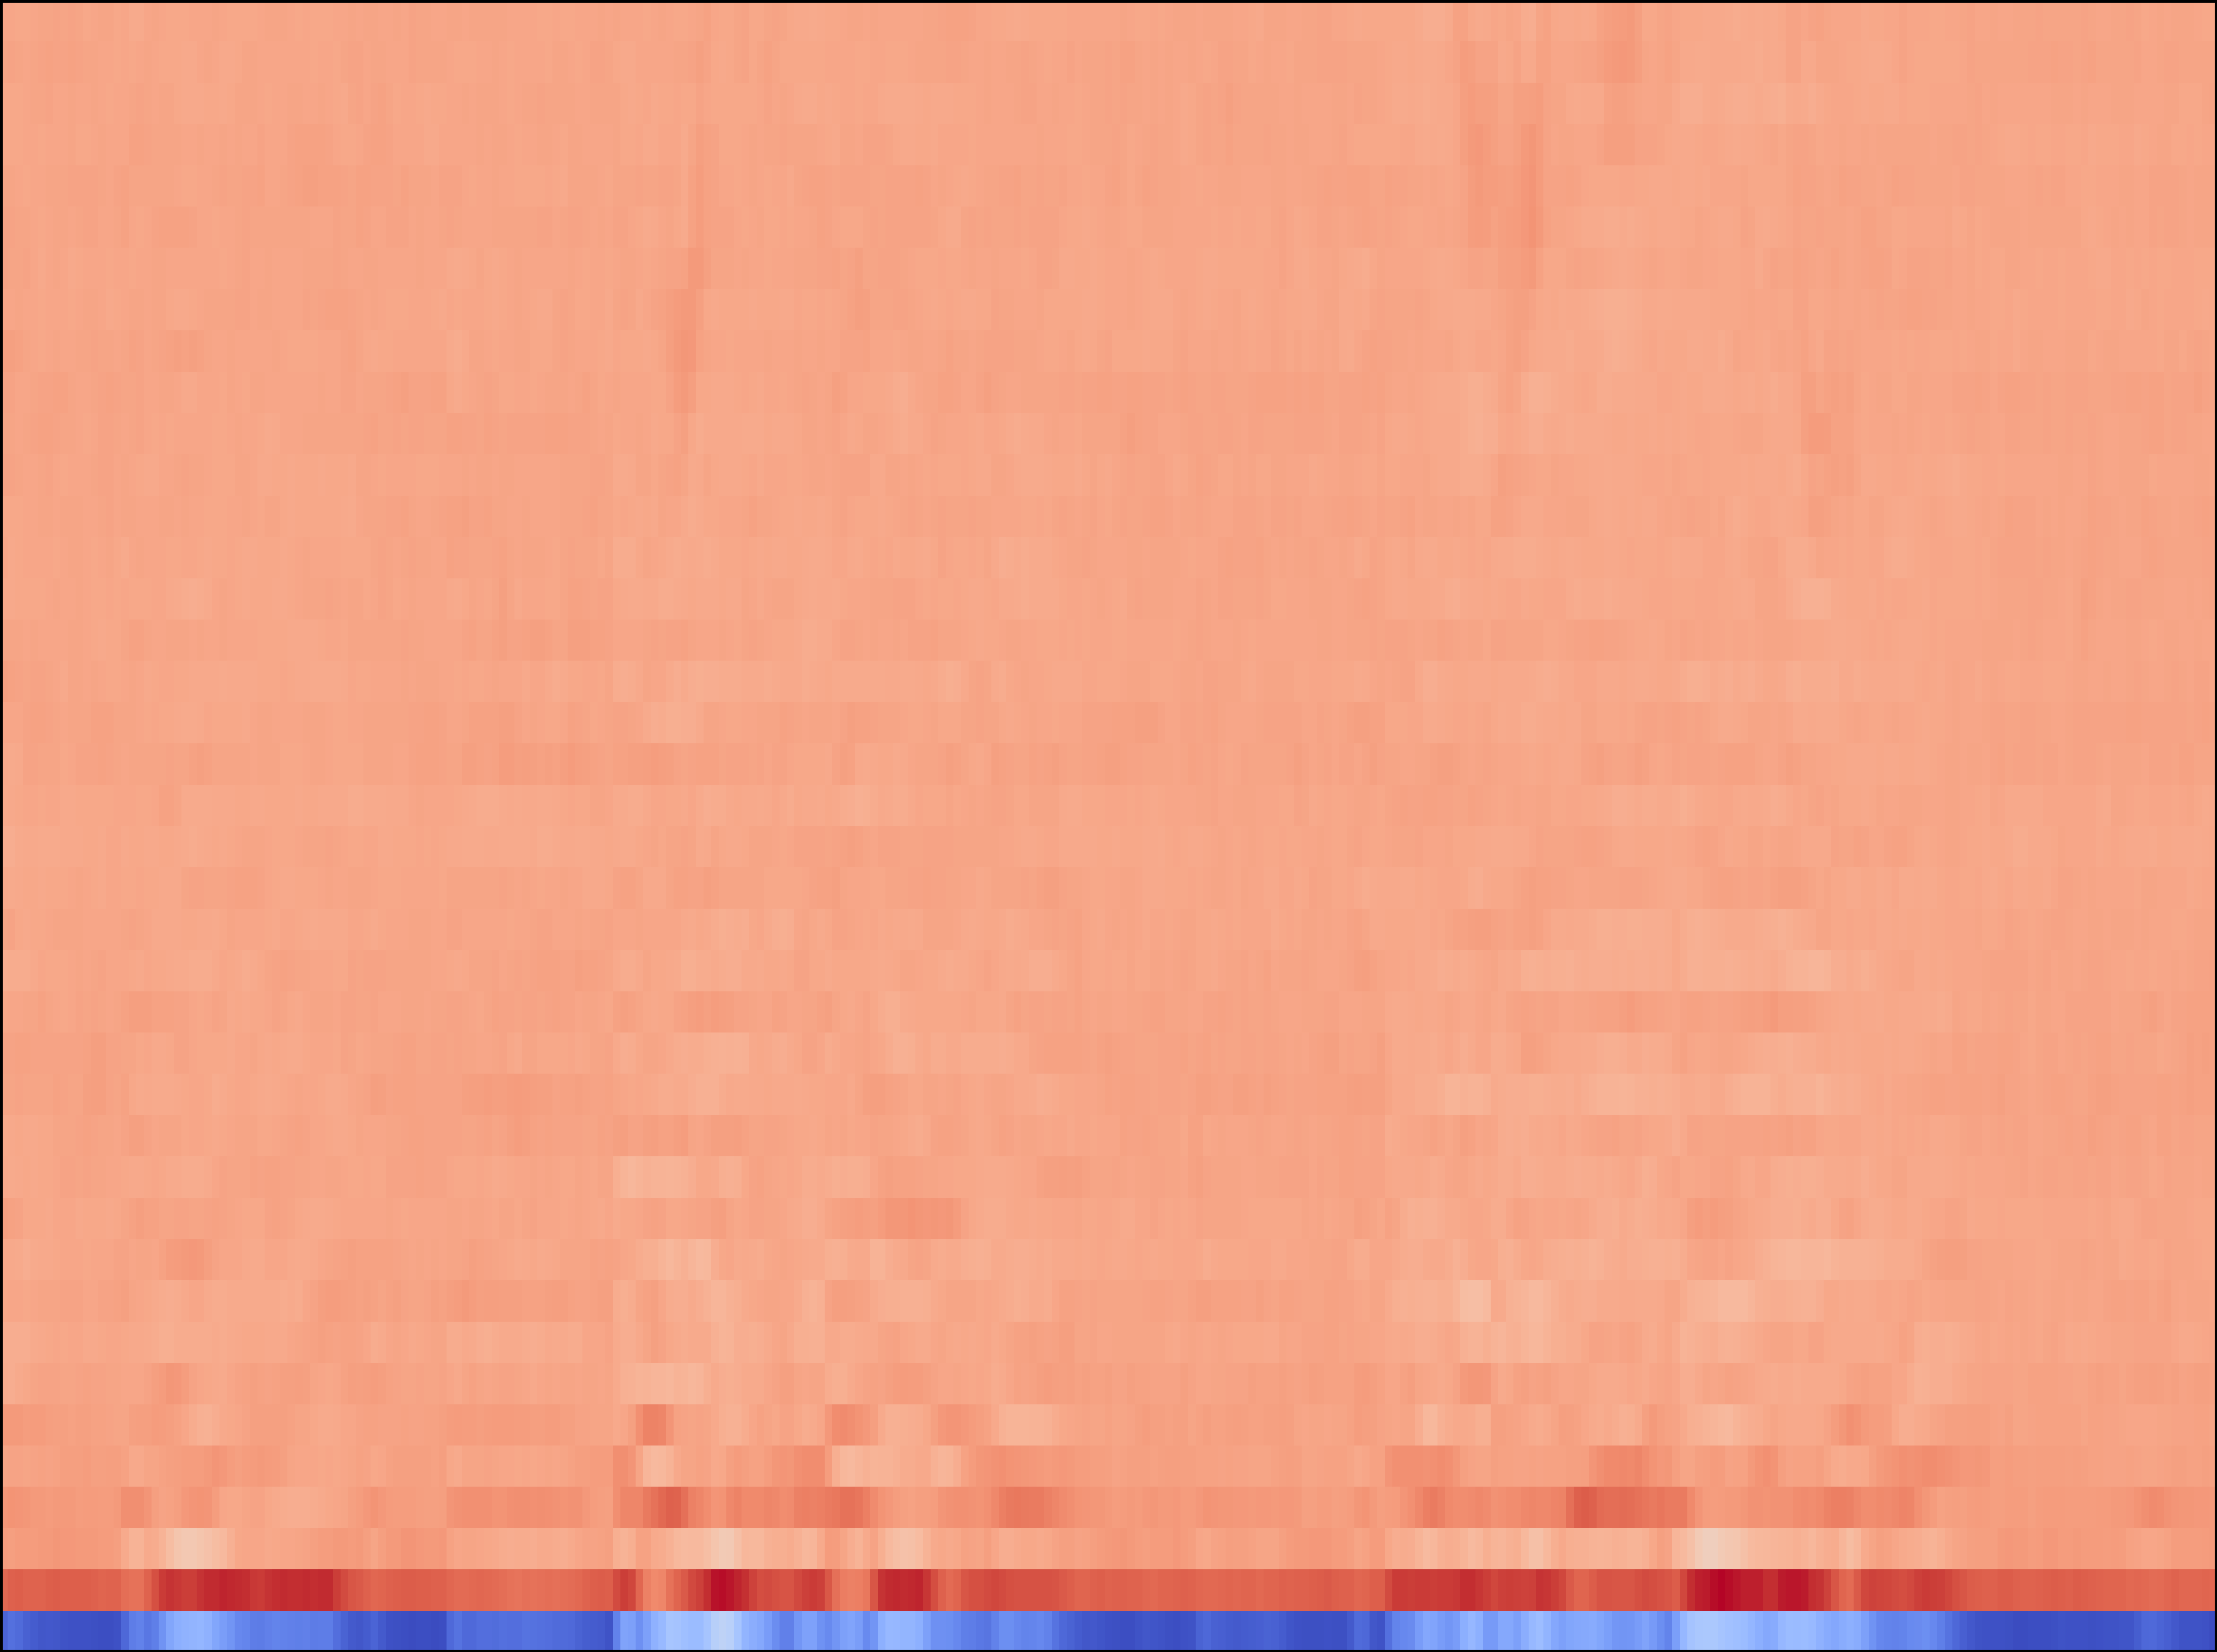

In [46]:
# print test.png
from IPython.display import Image
Image(filename='test.png')


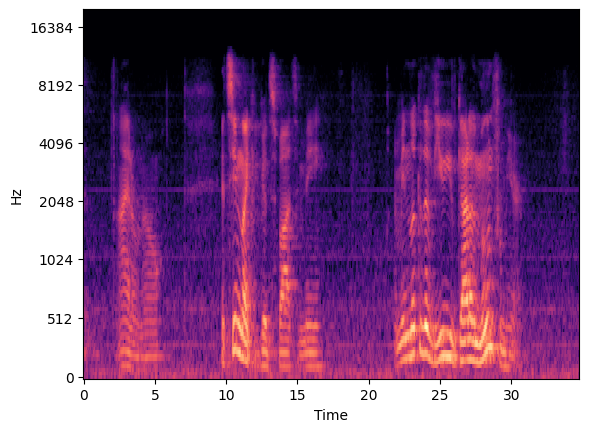

In [32]:
# Apply necessary preprocessing to generate the spectrogram representation
audio_spectogram = lb.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=100)

# Convert a power spectrogram (amplitude squared) to decibel (dB) units with power_to_db
audio_spectogram = lb.power_to_db(audio_spectogram, ref=np.max)

# Display the spectrogram with specshow
lb.display.specshow(audio_spectogram, y_axis='mel', fmax=20000, x_axis='time')
path_save1 =  "lion_king.jpg"
plt.savefig(path_save1)

In [176]:
import skimage.io
# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


# Create a function to export the mel spectrogram as an image for the CNN training
def extract_mel_spectrogram(file_path, output_path):
    """
        This function uses librosa to extract the mel spectrogram to an image and save the image in a folder
        file_path: Path to the audio file
        output_path: Path to save the image
    """
    # Load the audio file
    audio, sr = lb.load(file_path)

    # Extract the mel spectrogram
    audio_spectogram = lb.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=100)

    # Convert a power spectrogram (amplitude squared) to decibel (dB) units with power_to_db
    audio_spectogram = lb.power_to_db(audio_spectogram, ref=np.max)

    # Display the spectrogram with specshow
    lb.display.specshow(audio_spectogram, y_axis='mel', fmax=20000, x_axis='time')

    # remove the axis
    plt.axis('off')
    
    # Save the figure
    plt.savefig(output_path, dpi=1000, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close('all')

In [172]:
# check which files in the img folder are not in the df
img_files = os.listdir('/Users/giliardyminicucci/Documents/University/3rdYear/Final project/1 - My Proj/Coding2/IEMOCAP/img')
# remove .png from the file names
img_files = [file.replace('.png', '') for file in img_files]

df_files = df.filename.to_list()

# get the files that are in the df but in the img folder
files_to_extract = [file for file in df_files if file not in img_files]


In [173]:
# filter dataframe to only include the files that are not in the img folder
df_extract = df[df['filename'].isin(files_to_extract)]

# filter out the emotion xxx
df_extract = df_extract[df_extract['emotion_label'] != 'xxx']

df_extract

,filename,filepath,emotion,transcription,dataset,emotion_label,gender,method,session,nr_filepath,clean_text,num_label
13,Ses04M_script02_2_F000,IEMOCAP/Session4/sentences/wav/Ses04M_script02...,neu,"Look at this, goose bumps.",IEMOCAP,neutral,F,script,4,NormalisedAudio/IEMOCAP/Ses04M_script02_2_F000...,look at this goose bump,2


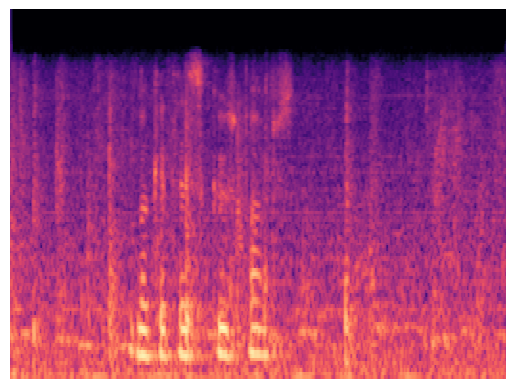

In [177]:
extract_mel_spectrogram('IEMOCAP/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F000.wav', 'IEMOCAP/img/Ses04M_script02_2_F000.png')

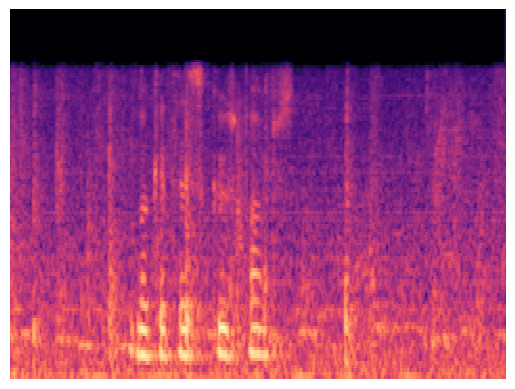

In [179]:
extract_mel_spectrogram('NormalisedAudio/IEMOCAP/Ses04M_script02_2_F000_NR.wav', 'IEMOCAP/img/Ses04M_script02_2_F000.png')

In [174]:
# add new column to the dataframe with the path to the mel spectrogram image
# df['mel_spectrogram'] = df['filepath'].apply(lambda x: x.replace('wav', 'png'))

# # iterate over the dataframe and extract the mel spectrogram
for idx, row in df_extract.iterrows():
    output_path = ('IEMOCAP/img/' + row['filename'] + '.png')
    file_path = row['nr_filepath']
    extract_mel_spectrogram(file_path, output_path)

IEMOCAP/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F000.wav


In [ ]:
# Create from imagenet style dataset in path with train and valid subfolders (or provide valid_pct)
# data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [14]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.widgets import *

In [15]:
from fastai.vision.all import *
from librosa.feature import melspectrogram
from librosa.core import load

In [17]:
from fastai.data.all import *

In [18]:
class AudioItem(ItemBase):
    def __init__(self, path):
        self.path = path

class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=(".wav", ".mp3"), recursive=False):
        return cls([AudioItem(os.path.join(path, f)) for f in Path(path).glob(f"*({','.join(extensions)})") if not f.is_dir() and recursive or f.is_file()])


NameError: name 'ItemBase' is not defined

In [206]:
# create a folder for train data with each subfolder for each emotion
directories = ['IEMOCAP/train', 'IEMOCAP/validation', 'IEMOCAP/test']
emotions = df.emotion_label.unique()
print(emotions)

for directory in directories:
    os.makedirs(directory, exist_ok=True)

    for emotion in emotions:
        os.makedirs(directory + '/' + emotion, exist_ok=True)


def move_files(df, directory):
    """
        This function moves the files to the train, validation and test folders
        df: Dataframe
        directory: Directory to move the files to
    """
    # create a subfolder for each emotion in the train folder
    for idx, row in df.iterrows():
        # get the emotion label
        emotion = row['emotion_label']
        # get the file name
        filename = row['filename']
        # get the image path
        image_path = row['image_path']
        
        # move the file to the correct folder
        shutil.copy(image_path, directory + '/' + emotion + '/' + filename + '.png')

['happy' 'angry' 'neutral' 'frustrated' 'sad' 'excited']


In [211]:
# # move the files to the train folder
# # move_files(train_df, 'IEMOCAP/train')

# # move the files to the validation folder
# move_files(val_df, 'IEMOCAP/validation')

# # move the files to the test folder
# move_files(test_df, 'IEMOCAP/test')

In [227]:
# resize the images to 224x224
# resize_images('IEMOCAP/train')
resize_images('IEMOCAP/validation')
# resize_images('IEMOCAP/test')

# create a function to resize the images
def resize_images(directory):
    """
        This function resizes the images to 224x224
        directory: Directory to resize the images
    """
    # get the list of emotions
    emotions = os.listdir(directory)

    # iterate over the emotions
    for emotion in emotions:
        # get the list of files
        files = os.listdir(directory + '/' + emotion)

        # iterate over the files
        for file in files:
            # get the image path
            image_path = directory + '/' + emotion + '/' + file

            # open the image
            image = Image.open(image_path)

            # resize the image
            image = image.resize((224, 224))

            # save the image
            image.save(image_path)

In [224]:
from fastai.vision import ImageDataBunch

data = ImageDataBunch.from_folder("IEMOCAP/validation", img_size=288)


ImportError: cannot import name 'ImageDataBunch' from 'fastai.vision' (/usr/local/lib/python3.11/site-packages/fastai/vision/__init__.py)

In [219]:
train_path = 'IEMOCAP/validation'

# data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

# Create from imagenet style dataset in path with train and valid subfolders (or provide valid_pct)
data = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42, num_workers=0)

In [1]:
# train using fastai cnn_learner with resnet34

train = cnn_learner(data, models.resnet34, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

NameError: name 'cnn_learner' is not defined

In [221]:
data.vocab

['angry', 'excited', 'frustrated', 'happy', 'neutral', 'sad']

In [222]:
# data.show_batch(figsize=(7,8))

In [223]:
train.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: Invalid buffer size: 3.28 GB